In [1]:
%pip install -q amplpy
from amplpy import AMPL, ampl_notebook
ampl = ampl_notebook(
    modules=["highs"], # install HiGHS
    license_uuid="c6feb3b0-91be-42a2-ac0f-680b62ad5008")
    # your license UUID (e.g., free ampl.com/ce or ampl.com/courses licenses)

Note: you may need to restart the kernel to use updated packages.
Licensed to AMPL Community Edition License for <damien.pantalos@student.innoenergy.com>.


In [ ]:
import pandas as pd
solar_gen=pd.read_csv('data/solar1.csv',header=None,skiprows=4, index_col=None)
solar_gen.drop(columns=[0,1],inplace=True)
# reset the index to start from 0
solar_gen.reset_index(drop=True,inplace=True)

# add wind 
wind_gen=pd.read_csv('data/wind1.csv',header=None,skiprows=4, index_col=None)
wind_gen.drop(columns=[0,1,3],inplace=True)
# reset the index to start from 0
wind_gen.reset_index(drop=True,inplace=True)



       2
0  0.000
1  0.000
2  0.000
3  0.000
4  0.000
5  0.000
6  0.000
7  0.026
8  0.254
9  0.489
       2
0  0.137
1  0.070
2  0.042
3  0.045
4  0.061
5  0.074
6  0.077
7  0.077
8  0.072
9  0.062


## Version 1 

Best version 

In [ ]:
import pandas as pd
import pyomo.environ as pyo

# Load demand data
l_t = list(range(24*365))
load = pd.read_excel('dades_dem_cat.xlsx', sheet_name="Full2", header=None, index_col=0)
Pload = {t: float(load[1][t+1]) for t in l_t}

# Load solar generation data
solar_gen = pd.read_csv('data/solar1.csv', header=None, skiprows=4, index_col=None)
solar_gen.drop(columns=[0, 1], inplace=True)
solar_gen.reset_index(drop=True, inplace=True)
solar_gen=solar_gen/1000 # Convert to MW

# Load wind generation data
wind_gen = pd.read_csv('data/wind1.csv', header=None, skiprows=4, index_col=None)
wind_gen.drop(columns=[0, 1, 3], inplace=True)
wind_gen.reset_index(drop=True, inplace=True)
wind_gen=wind_gen/1000 # Convert to MW


# Define the model
model = pyo.ConcreteModel()

# Define sets
model.T = pyo.Set(initialize=l_t)

# Define parameters
model.Pload = pyo.Param(model.T, initialize=Pload)
model.solar_gen = pyo.Param(model.T, initialize={t: solar_gen.iloc[t, 0] for t in l_t})
model.wind_gen = pyo.Param(model.T, initialize={t: wind_gen.iloc[t, 0] for t in l_t})

# Define variables
model.Psolar = pyo.Var(within=pyo.NonNegativeReals)
model.Pwind = pyo.Var(within=pyo.NonNegativeReals)
model.Pnuc = pyo.Var(within=pyo.NonNegativeReals)
model.Ppgas = pyo.Var(within=pyo.NonNegativeReals)
model.Pgas_t = pyo.Var(model.T, within=pyo.NonNegativeReals)

# Objective function: Minimize the total cost
def func_obj(m):
    CAPEX_nuc = m.Pnuc * 3600 * 10**3
    OPEX_nuc = m.Pnuc * 90 * 10**3 * 365
    CAPEX_gas = m.Ppgas * 823 * 10**3
    OPEX_gas = sum(m.Pgas_t[t] * 1 for t in l_t) * 365 * 25 * 10**3
    CAPEX_solar = m.Psolar * 900 * 10**3
    OPEX_solar = (m.Psolar * 365 * 15 * 10**3) / 2
    CAPEX_wind = m.Pwind * 1300 * 10**3
    OPEX_wind = (m.Pwind * 365 * 35 * 10**3) / 2
    return (CAPEX_nuc + OPEX_nuc * 50 + CAPEX_gas + OPEX_gas * 50 +
            CAPEX_solar + OPEX_solar * 50 + CAPEX_wind + OPEX_wind * 50)
model.TotalCost = pyo.Objective(rule=func_obj, sense=pyo.minimize)

# Constraints
def demand_constraint_rule(m, t):
    return (m.Psolar * m.solar_gen[t] +
            m.Pwind * m.wind_gen[t] +
            m.Pnuc +
            m.Pgas_t[t] == m.Pload[t])
model.DemandConstraint = pyo.Constraint(model.T, rule=demand_constraint_rule)

# Solve the problem
solver = pyo.SolverFactory('glpk')
solver.solve(model)

# Print the results
print(f"Optimal Solar Capacity: {pyo.value(model.Psolar)}")
print(f"Optimal Wind Capacity: {pyo.value(model.Pwind)}")
print(f"Optimal Nuclear Capacity: {pyo.value(model.Pnuc)}")
print(f"Optimal Gas Capacity: {pyo.value(model.Ppgas)}")
print(f"Total Cost: {pyo.value(model.TotalCost)}")

import matplotlib.pyplot as plt

# Extract the results
Psolar = pyo.value(model.Psolar)
Pwind = pyo.value(model.Pwind)
Pnuc = pyo.value(model.Pnuc)
Pgas_t = [pyo.value(model.Pgas_t[t]) for t in l_t]

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(l_t, [Psolar * solar_gen.iloc[t, 0] for t in l_t], label='Solar Generation')
plt.plot(l_t, [Pwind * wind_gen.iloc[t, 0] for t in l_t], label='Wind Generation')
plt.plot(l_t, [Pnuc] * len(l_t), label='Nuclear Generation')
plt.plot(l_t, Pgas_t, label='Gas Generation')
plt.plot(l_t, [Pload[t] for t in l_t], label='Load', linestyle='--')

plt.xlabel('Time (hours)')
plt.ylabel('Power (MW)')
plt.title('Power Generation and Load Over 24 Hours')
plt.legend()
plt.grid(True)
plt.show()

## Version 2

Oldest version

{None: 3299.67}
{0: 666.5699999999997, 1: 513.6399999999999, 2: 323.46, 3: 155.5, 4: 40.42999999999984, 5: 0.0, 6: 41.15999999999985, 7: 120.1199999999999, 8: 76.67999999999984, 9: 242.1100000000001, 10: 504.0299999999997, 11: 719.8800000000001, 12: 841.3599999999997, 13: 955.4300000000003, 14: 926.1000000000004, 15: 750.69, 16: 705.8699999999999, 17: 895.1700000000001, 18: 1291.68, 19: 1447.45, 20: 1606.66, 21: 1603.51, 22: 1326.13, 23: 914.3900000000003}
{0: -0.0, 1: -0.0, 2: -0.0, 3: -0.0, 4: -0.0, 5: 0.0, 6: -0.0, 7: -0.0, 8: -0.0, 9: -0.0, 10: -0.0, 11: -0.0, 12: -0.0, 13: -0.0, 14: -0.0, 15: -0.0, 16: -0.0, 17: -0.0, 18: -0.0, 19: -0.0, 20: -0.0, 21: -0.0, 22: -0.0, 23: -0.0}
{0: -0.0, 1: -0.0, 2: -0.0, 3: -0.0, 4: -0.0, 5: 0.0, 6: -0.0, 7: -0.0, 8: -0.0, 9: -0.0, 10: -0.0, 11: -0.0, 12: -0.0, 13: -0.0, 14: -0.0, 15: -0.0, 16: -0.0, 17: -0.0, 18: -0.0, 19: -0.0, 20: -0.0, 21: -0.0, 22: -0.0, 23: -0.0}


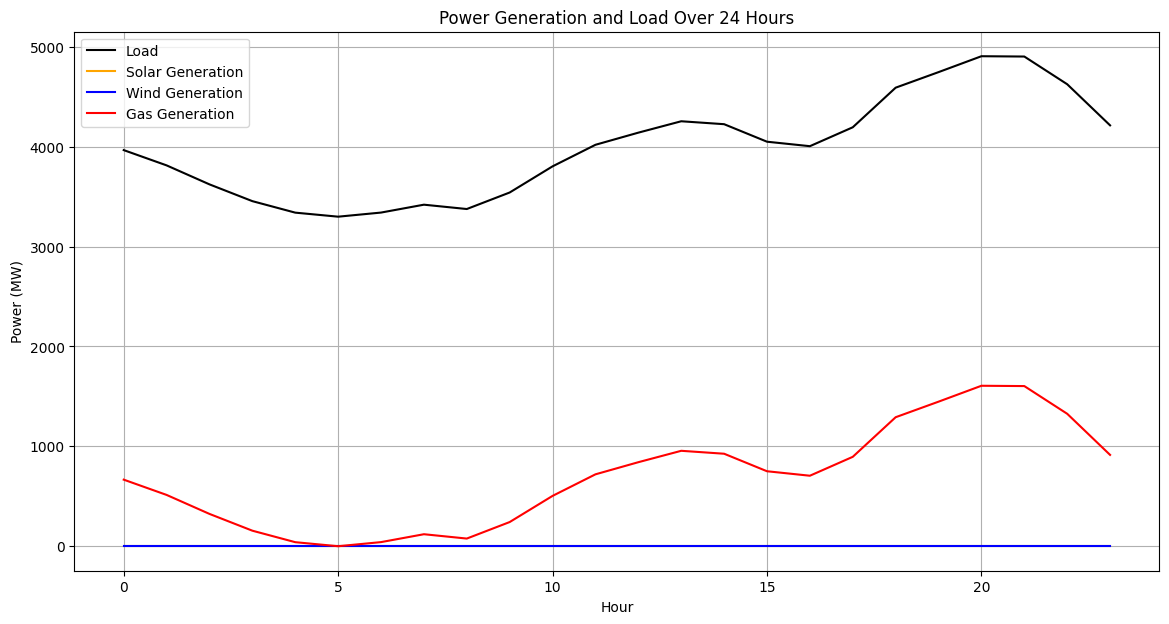

In [16]:
import pyomo.environ as pyo  # requires Pyomo
import pandas as pd  # requires pandas

# Load demand data
l_t = list(range(24))
load = pd.read_excel('dades_dem_cat.xlsx', sheet_name="Full2", header=None, index_col=0)
Pload = {t: float(load[1][t+1]) for t in l_t}

# Load solar generation data from the CSV file (replace 'solar_data.csv' with your file name)
solar_data = solar_gen/1000
wind_data = wind_gen/1000
Psolar = {t: float(solar_data[2][t]) for t in l_t} # solar generation in Wh
Pwind = {t: float(wind_data[2][t]) for t in l_t} # wind generation in Wh

# Create Pyomo model
model = pyo.ConcreteModel()
model.t = pyo.Set(initialize=l_t)

# Define variables for nuclear, gas, and solar generation
model.Pnuc = pyo.Var(within=pyo.NonNegativeReals)
model.Ppgas = pyo.Var(within=pyo.NonNegativeReals)
model.Pgas_t = pyo.Var(model.t, within=pyo.NonNegativeReals)
model.Psolar_t = pyo.Var(model.t, within=pyo.NonNegativeReals, initialize=Psolar)

# adding solar capacity
model.Psolar = pyo.Var(within=pyo.NonNegativeReals)

# adding wind 
model.Pwind = pyo.Var(within=pyo.NonNegativeReals)
model.Pwind_t = pyo.Var(model.t, within=pyo.NonNegativeReals, initialize=Pwind)

# Update energy balance constraint to include solar generation
def Constraint_balance(m, t):
    return m.Pnuc + m.Pgas_t[t] + m.Psolar_t[t] + m.Pwind_t[t] == Pload[t]

model.Constr_balance = pyo.Constraint(model.t, rule=Constraint_balance)

# Gas size constraint
def Constraint_gas_size(m, t):
    return m.Pgas_t[t] <= m.Ppgas

model.Constr_gas_size = pyo.Constraint(model.t, rule=Constraint_gas_size)


def Constraint_solar_size(m,t):
    return m.Psolar_t[t] <= Psolar[t]*m.Psolar

model.Constr_solar_size = pyo.Constraint(model.t, rule=Constraint_solar_size)

def Constraint_wind_size(m,t):
    return m.Pwind_t[t] <= Pwind[t]*m.Pwind

model.Constr_wind_size = pyo.Constraint(model.t, rule=Constraint_wind_size)


# Objective function (CAPEX, OPEX, etc.)
# Assuming operational life of 50 years
def func_obj(m):
    CAPEX_nuc = m.Pnuc * 3600 * 10**3
    OPEX_nuc = m.Pnuc * 0.02 * 10**3 * 8760
    CAPEX_gas = m.Ppgas * 823 * 10**3
    OPEX_gas = sum(m.Pgas_t[t] * 1 for t in l_t) * 365 * 0.15 * 10**3
    # adding solar costs
    CAPEX_solar =m.Psolar * 2
    OPEX_solar = (m.Psolar * 365 * 0.1 * 10**3)/2 
    CAPEX_wind =m.Pwind * 1000
    OPEX_wind = (m.Pwind * 365 * 0.1 * 10**3)/2
    return CAPEX_nuc + OPEX_nuc * 50 + CAPEX_gas + OPEX_gas * 50 + CAPEX_solar + OPEX_solar * 50  + CAPEX_wind + OPEX_wind * 50

model.goal = pyo.Objective(rule=func_obj, sense=pyo.minimize)

# Solve model
opt = pyo.SolverFactory('highs')
results = opt.solve(model)

# Display results
print(model.Pnuc.get_values())
print(model.Pgas_t.get_values())

# solar
print(model.Psolar_t.get_values())

# wind
print(model.Pwind_t.get_values())
# Convert results to DataFrame
results_df = pd.DataFrame({
    'Hour': l_t,
    'Load': [Pload[t] for t in l_t],
    'Solar Generation': [model.Psolar_t[t].value for t in l_t],
    'Wind Generation': [model.Pwind_t[t].value for t in l_t],
    'Gas Generation': [model.Pgas_t[t].value for t in l_t]
})

results_df.head(24)

import matplotlib.pyplot as plt

# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(results_df['Hour'], results_df['Load'], label='Load', color='black')
plt.plot(results_df['Hour'], results_df['Solar Generation'], label='Solar Generation', color='orange')
plt.plot(results_df['Hour'], results_df['Wind Generation'], label='Wind Generation', color='blue')
plt.plot(results_df['Hour'], results_df['Gas Generation'], label='Gas Generation', color='red')
plt.xlabel('Hour')
plt.ylabel('Power (MW)')
plt.title('Power Generation and Load Over 24 Hours')
plt.legend()
plt.grid(True)
plt.show()



In [12]:
# Check if the solver found an optimal solution
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    # Display the total cost
    total_cost = pyo.value(model.goal)
    print("Total cost:", round(total_cost/1e6,3), "M€")
else:
    print("No optimal solution found.")

NameError: name 'results' is not defined

# Define Renewables mix (20%, 40%, 60%, 80%, 100%)


In [5]:
import pyomo.environ as pyo
import pandas as pd
import logging
logging.getLogger('pyomo').setLevel(logging.ERROR)


# Load demand profile
l_t = list(range(24))
load = pd.read_excel('dades_dem_cat.xlsx', sheet_name="Full2", header=None, index_col=0)
Pload = {t: float(load[1][t+1]) for t in l_t}

# Load solar generation data
solar_data = solar_gen
Psolar = {t: float(solar_data[2][t]) for t in l_t}

# Initialize model
model = pyo.ConcreteModel()
model.t = pyo.Set(initialize=l_t)

# Define Variables
model.Pnuc = pyo.Var(within=pyo.NonNegativeReals)  # Nuclear capacity
model.Ppgas = pyo.Var(within=pyo.NonNegativeReals)  # Gas capacity
model.Pgas_t = pyo.Var(model.t, within=pyo.NonNegativeReals)  # Gas generation per hour
model.Psolar_t = pyo.Var(model.t, within=pyo.NonNegativeReals, initialize=Psolar)  # Solar generation per hour
model.Psolar = pyo.Var(within=pyo.NonNegativeReals)  # Solar capacity

# Constraints
def Constraint_balance(m, t):
    # Energy balance for each hour: supply meets demand
    return m.Pnuc + m.Pgas_t[t] + m.Psolar_t[t] == Pload[t]

model.Constr_balance = pyo.Constraint(model.t, rule=Constraint_balance)

def Constraint_gas_size(m, t):
    # Ensure gas generation per hour does not exceed installed gas capacity
    return m.Pgas_t[t] <= m.Ppgas

model.Constr_gas_size = pyo.Constraint(model.t, rule=Constraint_gas_size)

def Constraint_solar_size(m, t):
    # Ensure solar generation per hour does not exceed installed solar capacity times solar availability
    return m.Psolar_t[t] <= Psolar[t] * m.Psolar

model.Constr_solar_size = pyo.Constraint(model.t, rule=Constraint_solar_size)

# Renewable penetration constraint function
def Constraint_renewable_penetration(m, penetration):
    # Total demand across all hours
    total_demand = sum(Pload[t] for t in m.t)
    # Total renewable (solar) generation across all hours
    renewable_generation = sum(m.Psolar_t[t] for t in m.t)
    # Ensure renewable generation meets the specified penetration target
    return renewable_generation >= penetration * total_demand

# Objective function - Minimize total cost
def func_obj(m):
    # CAPEX and OPEX for nuclear, gas, and solar
    CAPEX_nuc = m.Pnuc * 3600 * 10**3  # Nuclear CAPEX
    OPEX_nuc = m.Pnuc * 0.02 * 10**3 * 8760  # Nuclear OPEX
    CAPEX_gas = m.Ppgas * 823 * 10**3  # Gas CAPEX
    OPEX_gas = sum(m.Pgas_t[t] for t in m.t) * 365 * 0.15 * 10**3  # Gas OPEX
    CAPEX_solar = m.Psolar * 1000  # Solar CAPEX
    OPEX_solar = m.Psolar * 365 * 0.1 * 10**3  # Solar OPEX

    return (CAPEX_nuc + OPEX_nuc * 50 + CAPEX_gas + OPEX_gas * 50 +
            CAPEX_solar + OPEX_solar * 50)

model.goal = pyo.Objective(rule=func_obj, sense=pyo.minimize)

# Solver
opt = pyo.SolverFactory('highs')
penetration_levels = [i / 100 for i in range(0, 101)]  # 0% to 100% renewable targets in 1% increments
# write a range of penetration levels instead of a single value


# Store results for each scenario
results_summary = {}

# Scenario analysis loop
for penetration in penetration_levels:
    # Delete existing renewable penetration constraint if it exists
    if hasattr(model, 'renewable_penetration'):
        model.del_component(model.renewable_penetration)

    # Add renewable penetration constraint with the specified target
    model.renewable_penetration = pyo.Constraint(expr=Constraint_renewable_penetration(model, penetration))
    
    # Solve the model
    results = opt.solve(model)
    
    if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
        # Capture cost and capacities for this scenario
        total_cost = pyo.value(model.goal)
        renewable_capacity = pyo.value(model.Psolar)
        gas_capacity = pyo.value(model.Ppgas)
        nuclear_capacity = pyo.value(model.Pnuc)
        
        # Store results
        results_summary[penetration] = {
            "Total Cost": total_cost,
            "Solar Capacity Required": renewable_capacity,
            "Gas Capacity Required": gas_capacity,
            "Nuclear Capacity Required": nuclear_capacity,
        }
    else:
        print(f"No optimal solution found for {penetration*100}% renewables.")

try:
    results = opt.solve(model)
except Exception as e:
    # Handle any errors if necessary
    pass

# Check results and print custom message if infeasible
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    # Proceed with result processing
    total_cost = pyo.value(model.goal)
    renewable_capacity = pyo.value(model.Psolar)
    gas_capacity = pyo.value(model.Ppgas)
    nuclear_capacity = pyo.value(model.Pnuc)
    results_summary[penetration] = {
        "Total Cost": total_cost,
        "Solar Capacity Required": renewable_capacity,
        "Gas Capacity Required": gas_capacity,
        "Nuclear Capacity Required": nuclear_capacity,
    }
else:
    # Custom handling for infeasible scenarios without warning printout
    print(f"No optimal solution found for {penetration*100}% renewables.")

# Display results summary
for penetration, result in results_summary.items():
    print(f"Renewable Target: {penetration*100}%")
    print(result)


No optimal solution found for 41.0% renewables.
No optimal solution found for 42.0% renewables.
No optimal solution found for 43.0% renewables.
No optimal solution found for 44.0% renewables.
No optimal solution found for 45.0% renewables.
No optimal solution found for 46.0% renewables.
No optimal solution found for 47.0% renewables.
No optimal solution found for 48.0% renewables.
No optimal solution found for 49.0% renewables.
No optimal solution found for 50.0% renewables.
No optimal solution found for 51.0% renewables.
No optimal solution found for 52.0% renewables.
No optimal solution found for 53.0% renewables.
No optimal solution found for 54.0% renewables.
No optimal solution found for 55.00000000000001% renewables.
No optimal solution found for 56.00000000000001% renewables.
No optimal solution found for 56.99999999999999% renewables.
No optimal solution found for 57.99999999999999% renewables.
No optimal solution found for 59.0% renewables.
No optimal solution found for 60.0% 

# C

In [6]:
import pyomo.environ as pyo
import pandas as pd

# Load demand profile
l_t = list(range(24))
load = pd.read_excel('dades_dem_cat.xlsx', sheet_name="Full2", header=None, index_col=0)
Pload = {t: float(load[1][t+1]) for t in l_t}

# Load solar generation data
solar_data = solar_gen  # Replace with actual file path
Psolar = {t: float(solar_data[2][t]) for t in l_t}

# Initialize model
model = pyo.ConcreteModel()
model.t = pyo.Set(initialize=l_t)

# Fixed Capacities for existing nuclear and gas plants
model.Pnuc = 2*1000  # 2 Nuclear plants, 1000 MW each
model.Ppgas = 3*700  # 3 Gas plants, 700 MW each

# Define Variables for gas generation per hour and solar capacity
model.Pgas_t = pyo.Var(model.t, within=pyo.NonNegativeReals)  # Gas generation per hour
model.Psolar_t = pyo.Var(model.t, within=pyo.NonNegativeReals, initialize=Psolar)  # Solar generation per hour
model.Psolar = pyo.Var(within=pyo.NonNegativeReals)  # Solar capacity to be optimized

# Constraints
def Constraint_balance(m, t):
    # Energy balance for each hour
    return m.Pnuc + m.Pgas_t[t] + m.Psolar_t[t] == Pload[t]

model.Constr_balance = pyo.Constraint(model.t, rule=Constraint_balance)

def Constraint_gas_size(m, t):
    # Ensure gas generation per hour does not exceed installed gas capacity
    return m.Pgas_t[t] <= m.Ppgas

model.Constr_gas_size = pyo.Constraint(model.t, rule=Constraint_gas_size)

def Constraint_solar_size(m, t):
    # Ensure solar generation per hour does not exceed installed solar capacity times solar availability
    return m.Psolar_t[t] <= Psolar[t] * m.Psolar

model.Constr_solar_size = pyo.Constraint(model.t, rule=Constraint_solar_size)

# Renewable penetration constraint function
def Constraint_renewable_penetration(m, penetration):
    # Total demand across all hours
    total_demand = sum(Pload[t] for t in m.t)
    # Total renewable (solar) generation across all hours
    renewable_generation = sum(m.Psolar_t[t] for t in m.t)
    # Ensure renewable generation meets the specified penetration target
    return renewable_generation >= penetration * total_demand

# Objective function - Minimize total cost
def func_obj(m):
    # Only OPEX for nuclear and gas (CAPEX is sunk)
    OPEX_nuc = m.Pnuc * 0.02 * 10**3 * 8760
    OPEX_gas = sum(m.Pgas_t[t] for t in m.t) * 365 * 0.15 * 10**3
    
    # CAPEX and OPEX for solar (new capacity)
    CAPEX_solar = m.Psolar * 1000
    OPEX_solar = m.Psolar * 365 * 0.1 * 10**3

    return OPEX_nuc * 50 + OPEX_gas * 50 + CAPEX_solar + OPEX_solar * 50

model.goal = pyo.Objective(rule=func_obj, sense=pyo.minimize)

# Solver
opt = pyo.SolverFactory('highs')
penetration_levels = [i / 100 for i in range(0, 101)]  # 0% to 100% renewable targets in 1% increments

# Store results for each scenario
results_summary = {}

# Scenario analysis loop
for penetration in penetration_levels:
    # Delete existing renewable penetration constraint if it exists
    if hasattr(model, 'renewable_penetration'):
        model.del_component(model.renewable_penetration)

    # Add renewable penetration constraint with the specified target
    model.renewable_penetration = pyo.Constraint(expr=Constraint_renewable_penetration(model, penetration))
    
    # Solve the model
    results = opt.solve(model)
    
    if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
        # Capture cost and capacities for this scenario
        total_cost = pyo.value(model.goal)
        renewable_capacity = pyo.value(model.Psolar)
        gas_capacity = model.Ppgas
        nuclear_capacity = model.Pnuc
        
        # Store results
        results_summary[penetration] = {
            "Total Cost": total_cost,
            "Solar Capacity Required": renewable_capacity,
            "Gas Capacity (Fixed)": gas_capacity,
            "Nuclear Capacity (Fixed)": nuclear_capacity,
        }
    else:
        print(f"No optimal solution found for {penetration*100}% renewables.")

# Display results summary
for penetration, result in results_summary.items():
    print(f"Renewable Target: {penetration*100}%")
    print(result)


No optimal solution found for 0.0% renewables.
No optimal solution found for 1.0% renewables.
No optimal solution found for 2.0% renewables.
No optimal solution found for 3.0% renewables.
No optimal solution found for 4.0% renewables.
No optimal solution found for 5.0% renewables.
No optimal solution found for 6.0% renewables.
No optimal solution found for 7.000000000000001% renewables.
No optimal solution found for 8.0% renewables.
No optimal solution found for 9.0% renewables.
No optimal solution found for 10.0% renewables.
No optimal solution found for 11.0% renewables.
No optimal solution found for 12.0% renewables.
No optimal solution found for 13.0% renewables.
No optimal solution found for 14.000000000000002% renewables.
No optimal solution found for 15.0% renewables.
No optimal solution found for 16.0% renewables.
No optimal solution found for 17.0% renewables.
No optimal solution found for 18.0% renewables.
No optimal solution found for 19.0% renewables.
No optimal solution fo